In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import edward as ed
from edward.models import (Dirichlet, Gamma,
                           ParamMixture, Poisson, Empirical, Categorical)
import tensorflow as tf
import zipfile
from final_utils import EM, info_crit, calc_prob

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


$\LARGE \mathbf {Introduction}$

The goal in appointment scheduling is to provide patients
with efficienct and timely access to health services.
This is hard in general because different
patients have different needs, and with limited
resources, we are
unlikely to satisfy the demands of all patients.
<br>
Many factors affect the performance of appointment
systems, but in this project,
we'll focus on how far in advance people
usually make appointments, and hopefully
this will help improve the scheduling procedure.
To this end, we will cycle through Box's
loop, and focus on the inference part.

$\LARGE \mathbf {Data}$

We will work with the  data that contains
the appointments scheduled
at Columbia University Medical
Center (CUMC) from 2010 to 2014.
<br>
Since the dataset is large, and there
are a few people that make appointments
as far as 1 year in advance, to make
the problem easier, we'll focus on
the data for people that make appointments
at most 30 days in advance.

In [2]:
zf = zipfile.ZipFile('Appointments.csv.zip')
df = pd.read_csv(zf.open('Appointments.csv'), sep=',')
appointment_made = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 5]]
appointment_date = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 6]]
delay = np.busday_count(appointment_made, appointment_date, weekmask='1111111')
delay = [float(x) for x in delay if x >= 0]
delay = [x for x in delay if x <= 30]
N = len(delay)
print(N)

491831


mean: 9.47753801610716
variance: 83.55146707147975


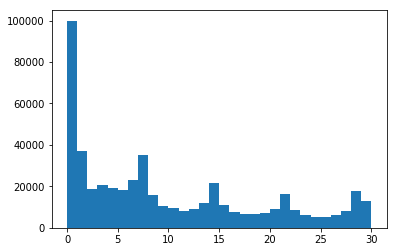

In [3]:
print('mean:', np.mean(delay))
print('variance:', np.var(delay))
plt.hist(delay, bins=range(31))
plt.show()

$\LARGE \mathbf {Model: Poisson\; Mixture}$

The number of days that people make
appointments in advance is a non-negative
integer, and we can see from the
plot that there are several peaks.
<br>
Therefore, we'll analyze the data with
a Poisson Mixture Model. Specifically, suppose
we have $K$ Poisson distributions
with parameters $\lambda_{1},...,\lambda_{K}$
mixed together with
proportions $p_{1},...,p_{K}$. Let
$\theta=(\lambda_{1},...,\lambda_{K},p_{1},...,p_{K})$,
then the likelihood is
$$f(X|\theta)=\prod_{i=1}^{N}\sum_{k=1}^{K}
p_{k}e^{-\lambda_{k}}\frac{\lambda_{k}^{X_{i}}}{X_{i}!}.$$

$\LARGE \mathbf {Inference: Frequentist\; and\; Bayesian}$

We'll start from a frequentist's point of view,
and try to find the parameters that maximize the
likelihood. Since it's hard to do this directly, we'll use the
EM algorithm, and update the parameters as follows:
$$\begin{align*}
q(k,i) & \leftarrow p_{k}Poisson(X_{i},\lambda_{k})\\
p(k|i) & \leftarrow\frac{q(k,i)}{\sum_{k=1}^{K}q(k,i)}\\
z(k) & \leftarrow\sum_{i=1}^{N}p(k|i)\\
p_{k} & \leftarrow\frac{z(k)}{N}\\
\lambda_{k} & \leftarrow\frac{\sum_{i=1}^{N}p(k|i)X_{i}}{z(k)}
\end{align*}$$

In [4]:
pi_EM, lam_EM, q_EM = EM(4, N, delay)
print('mixing proportion: ', pi_EM)
print('cluster mean: ', lam_EM)

mixing proportion:  [0.29077816 0.30589561 0.18488421 0.21844202]
cluster mean:  [ 0.38061447  5.59661077 13.54863022 23.57585386]


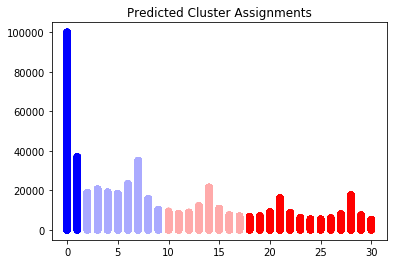

In [5]:
y = np.zeros(N)
for i in range(31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range(len(indices))]
    y[indices] = values
clusters = np.argmax(q_EM, 0)
plt.scatter(delay, y, c=clusters, cmap=cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

Now, we'll try to make inference from a
Bayesian point of view. We'll start with
variational inference. By expressing the
mixture model in terms of missing data, we'll introduce
indicator parameters $z's$ such that
$z_{ik}=1$ if the $i$-th observation belongs to the $k$-th
component and $z_{ik}=0$ otherwise.
To start, we use a non-informative Dirichlet
prior for $p's$, and Gamma priors with mean
equal to $10$ for  $\lambda's$. As for the posteriors,
we use Dirichlet for  $p's$, Gamma for
$\lambda's$, and Categorical for $z's$.

In [6]:
K = 4
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape=K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape=N)
z = x.cat

qpi_VI = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_VI", [K])))
qlam_VI = Gamma(tf.nn.softplus(tf.get_variable(
                "qlam_VI_a", [K])),
                tf.nn.softplus(tf.get_variable("qlam_VI_b", [K])))
qz_VI = Categorical(logits=tf.get_variable("qz_VI", [N, K]))

inference = ed.KLqp({lam: qlam_VI, pi: qpi_VI, z: qz_VI}, data={x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(20):
    print(inference.update())

{'t': 1, 'loss': 7720977.0}
{'t': 2, 'loss': 4636693.5}
{'t': 3, 'loss': 5339497.5}
{'t': 4, 'loss': 3919421.5}
{'t': 5, 'loss': 4807272.5}
{'t': 6, 'loss': 3790011.5}
{'t': 7, 'loss': 6706275.0}
{'t': 8, 'loss': 4062459.8}
{'t': 9, 'loss': 3985507.8}
{'t': 10, 'loss': 3609796.0}
{'t': 11, 'loss': 8129606.0}
{'t': 12, 'loss': 16172377.0}
{'t': 13, 'loss': 6202098.5}
{'t': 14, 'loss': 5808630.0}
{'t': 15, 'loss': 6323906.5}
{'t': 16, 'loss': 5563756.0}
{'t': 17, 'loss': 5622288.5}
{'t': 18, 'loss': 6874749.0}
{'t': 19, 'loss': 6656369.0}
{'t': 20, 'loss': 6340034.0}


As we can see, the problem is not as easy, and
if we just do a simple variational inference using Edward,
then the loss doesn't converge. This is
probably because the variance in BBVI is too
large. So we can try to simplify the inference
process by marginalizing out $z's$ and focus
on inferencing $p's$ and $\lambda's$. But just
doing this is not enough for the loss to converge,
so we also fix the mixing proportions. Specifically,
we fix $p's$ to be the values inferred from the EM
algorithm, and we set the Gamma priors of the
$\lambda's$ so that the means are the same
as what we get from the EM algorithm.

In [7]:
pi = tf.constant([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = Gamma([0.38061447, 5.59661077, 13.54863022, 23.57585386],
            [1.0, 1.0, 1.0, 1.0])

x = tf.gather(pi, 0)*Poisson(tf.gather(lam, 0), sample_shape=N)
for i in range(1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape=N)

qlam_fix = Gamma(tf.nn.softplus(tf.get_variable(
                "qlam_fix_a", [K])),
                tf.nn.softplus(tf.get_variable("qlam_fix_b", [K])))

inference = ed.KLqp({lam: qlam_fix}, data={x: delay})
inference.initialize(optimizer=tf.train.AdamOptimizer(1e-2))

sess = ed.get_session()
tf.global_variables_initializer().run()

for t in range(25000):
    loss = inference.update()
    if t == 0 or t == 24999:
        print(loss)

{'t': 1, 'loss': 126.22917}
{'t': 25000, 'loss': -0.23336887}


For this to work, we have to  explicitly specify
an optimer so that we can tune the parameters.
We use the Adam optimizer, and after some careful
tuning of the learning rate and the number of
training iterations, we see that the posteriors
for $\lambda's$ again have approximately the same
means, but the $\alpha's$ and $\beta's$ have
changed a lot from the priors.

In [8]:
print('alpha: ', qlam_fix.concentration.eval())
print('beta: ', qlam_fix.rate.eval())
print('mean: ', qlam_fix.mean().eval())

alpha:  [ 0.373412  5.674315 11.980584 15.900781]
beta:  [0.9724665  0.95911413 0.8708647  0.6614451 ]
mean:  [ 0.38398445  5.916204   13.757113   24.039457  ]


We can also fix $\lambda's$ to be the values
inferred from the EM algorithm, and make
inference for $p's$.

In [9]:
pi = Dirichlet([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = tf.constant([0.38061447, 5.59661077, 13.54863022, 23.57585386])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape=N)
for i in range(1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape=N)

qpi_fix = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_fix", [K])))

inference = ed.KLqp({pi: qpi_fix}, data={x: delay})
inference.initialize(optimizer=tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for t in range(7000):
    loss = inference.update()
    if t == 0 or t == 6999:
        print(loss)

{'t': 1, 'loss': 0.49332094}
{'t': 7000, 'loss': 0.025053501}


Again we have to tune the parameters for
the algorithm to converge, but it's harder
now because the initial loss is quite small,
so the prior is quite strong. After some
experimentations, we see that the means
of the Dirichlet posterior are close
to that of the prior, but the parameters have changed.

In [10]:
print('concentration: ', qpi_fix.concentration.eval())
print('mean: ', qpi_fix.mean().eval())

concentration:  [0.29723063 0.3148913  0.18831621 0.23035294]
mean:  [0.28835198 0.3054851  0.18269096 0.223472  ]


Building on the above two cases, we
can try to run an EM version of variational
inference by alternatively updating $p's$
and $\lambda's$. For the
loss to converge, in each iteration, we
update $p's$ once and then update $\lambda's$ ten times.

In [11]:
pi = Dirichlet([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = Gamma([0.38061447, 5.59661077, 13.54863022, 23.57585386],
            [1.0, 1.0, 1.0, 1.0])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape=N)
for i in range(1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape=N)

qpi = Dirichlet(tf.nn.softplus(tf.get_variable("qpi", [K])))
qlam = Gamma(
             tf.nn.softplus(tf.get_variable("qlam_a", [K])),
             tf.nn.softplus(tf.get_variable("qlam_b", [K]))
)

inference_e = ed.KLqp({pi: qpi}, data={x: delay})
inference_m = ed.KLqp({lam: qlam}, data={x: delay})
inference_e.initialize(optimizer=tf.train.AdamOptimizer(1e-3))
inference_m.initialize(optimizer=tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(6000):
    inference_e.update()
    for _ in range(10):
        inference_m.update()

We see that the results are actually
similar to what we get from making inference separately.

In [12]:
print('alpha: ', qlam.concentration.eval())
print('beta: ', qlam.rate.eval())
print('mean: ', qlam.mean().eval())

alpha:  [0.36102822 3.3400044  4.8751955  6.1770616 ]
beta:  [0.91632813 0.59143317 0.34695467 0.2659854 ]
mean:  [ 0.39399448  5.6473064  14.051391   23.22331   ]


In [13]:
print('concentration: ', qpi.concentration.eval())
print('mean: ', qpi.mean().eval())

concentration:  [0.32047132 0.33844158 0.1909489  0.24319838]
mean:  [0.29318726 0.3096276  0.17469203 0.22249314]


$\LARGE \mathbf {Criticism}$

To evaluate the model, we can first
use some information criteria such as AIC,
DIC and WAIC.
<br>
AIC uses a simple bias-corrected
adjustment of within-sample error, and
$$AIC = -2\times(logp(X|\hat{\theta}_{mle})-k).$$

In [14]:
# AIC
pi_EM = tf.constant(np.array([0.29077816, 0.30589561, 0.18488421, 0.21844202],
                             ndmin=2))
lam_EM = tf.constant(np.array([0.38061447,
                               5.59661077, 13.54863022, 23.57585386], ndmin=2))
elpd_AIC = 0
for i in range(31):
    log_EM, _ = calc_prob(pi_EM, lam_EM, np.float64(i), 1, K)
    elpd_AIC += log_EM * delay.count(i)
elpd_AIC -= 2 * K
AIC = -2 * elpd_AIC

In [15]:
print('AIC: ', AIC)

AIC:  3101315.840602224


DIC is a somewhat Bayesian version of AIC, and
$$DIC=-2\times(logp(X|\hat{\theta}_{Bayes})-p_{DIC}).$$

In [16]:
DIC_VI, WAIC_VI, lppd_VI, post_prob_VI = info_crit(qpi, qlam, K, delay)
print('DIC: ', DIC_VI)

DIC:  6266607.486829979


WAIC is a more fully Bayesian approach, and
$$WAIC=-2\times(lppd-p_{WAIC}).$$

In [17]:
print('WAIC: ', WAIC_VI)
print('lppd:', lppd_VI)

WAIC:  6197616.149034959
lppd: -1585683.0342659876


We can also plot the expected posterior probabilities.
But we notice that it's hard to see the
mixture pattern because the peaks are not very obvious.

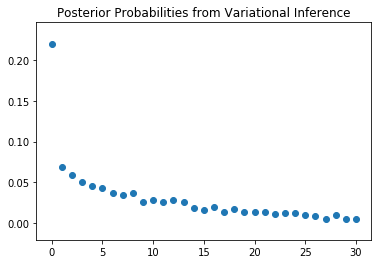

In [18]:
plt.scatter([x for x in range(31)], post_prob_VI)
plt.title('Posterior Probabilities from Variational Inference')
plt.show()

We can also do posterior predictive checks. The simplest
PPC works by applying a test statistic on many new
data generated from the posterior predictive
to induce a distribution. We
compare this distribution to the test
statistic on the real data.

In [19]:
post_prob = np.concatenate((post_prob_VI, [1 - np.sum(post_prob_VI)]))
T_X = np.zeros(100)
for i in range(100):
    X = np.argmax(np.random.multinomial(1, post_prob, size=N), axis=1)
    X = [x for x in X if x <= 30]
    T_X[i] = np.percentile(X, 75)

We see that the new datasets generated
from the variational posteriors
are somewhat different from our original dataset.

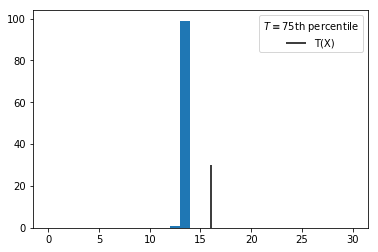

In [20]:
plt.hist(T_X, bins=range(31))
plt.vlines(np.percentile(delay, 75), ymin=0, ymax=30, label='T(X)')
plt.legend(title=r'$T \equiv$75th percentile')
plt.show()

We can also use the trained posteriors as
proposals for the Metropolis Hastings algorithm.
But we see that the acceptance rate is almost always
$0$, so it also shows that our variational
posteriors are not very good.

In [21]:
T = 500
qpi_MH = Empirical(tf.get_variable(
                  "qpi_MH", [T, K],
                  initializer=tf.constant_initializer(1.0 / K)))
qlam_MH = Empirical(tf.get_variable(
                   "qlam_MH", [T, K],
                   initializer=tf.zeros_initializer()))

inference = ed.MetropolisHastings({pi: qpi_MH,
                                   lam: qlam_MH}, {pi: qpi, lam: qlam},
                                  data={x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_MH.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  1/500 [  0%]                                ETA: 13360s | Acceptance Rate: nan
Inferred cluster means:
[0. 0. 0. 0.]
 10/500 [  2%]                                ETA: 1661s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 20/500 [  4%] █                              ETA: 813s | Acceptance Rate: 0.000 
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 30/500 [  6%] █                              ETA: 531s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 40/500 [  8%] ██                             ETA: 390s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 50/500 [ 10%] ███                            ETA: 305s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 60/500 [ 12%] ███                            ETA: 249s | Acceptance Rate: 0.000
Inferred

$\LARGE \mathbf {Better\; Inference}$

Fortunately, it's been shown
that if we use a Dirichlet prior for $p's$ and Gamma
priors for $\lambda's$, then the sampling steps are readily found to be:
$$\begin{align*}
z_{ik}\sim & Multinomial(1,w_{i1},...,w_{iK}),
\quad i=1,...,N,\quad k=1,...,K\\
 & where\quad w_{ik}=\frac{p_{k}f(X_{i}|\lambda_{k})}
 {f(X_{i})},\quad k=1,...,K\\
p\sim & Dirichlet(d_{1}+\sum_{i=1}^{N}w_{i1},...,d_{K}
+\sum_{i=1}^{N}w_{iK})\\
\lambda_{k}\sim & Gamma(a+\sum_{i=1}^{N}z_{ik}X_{i},
b+\sum_{i=1}^{N}z_{ik})I(\lambda_{k-1},
\lambda_{k+1}),\quad k=1,...,K
\end{align*}$$
So we can now implement Gibbs sampling.

In [22]:
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape=K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape=N)
z = x.cat

qpi_Gibbs = Empirical(tf.get_variable(
                     "qpi_Gibbs", [T, K],
                     initializer=tf.constant_initializer(1.0 / K)))
qlam_Gibbs = Empirical(tf.get_variable(
                      "qlam_Gibbs", [T, K],
                      initializer=tf.zeros_initializer()))
qz_Gibbs = Empirical(tf.get_variable(
                    "qz_Gibbs", [T, N],
                    initializer=tf.zeros_initializer(), dtype=tf.int32))

inference = ed.Gibbs({pi: qpi_Gibbs, lam: qlam_Gibbs,
                      z: qz_Gibbs}, data={x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_Gibbs.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 575s | Acceptance Rate: 1.000
Inferred cluster means:
[ 8.830353   8.246432  21.454596   1.3074889]
 10/500 [  2%]                                ETA: 415s | Acceptance Rate: 1.000
Inferred cluster means:
[ 8.623811    7.6835     21.563696    0.97138417]
 15/500 [  3%]                                ETA: 364s | Acceptance Rate: 1.000
Inferred cluster means:
[ 8.833792   7.0612445 21.549973   0.8062967]
 20/500 [  4%] █                              ETA: 332s | Acceptance Rate: 1.000
Inferred cluster means:
[ 9.264275    6.6018844  21.676126    0.70333135]
 25/500 [  5%] █                              ETA: 311s | Acceptance Rate: 1.000
Inferred cluster means:
[ 9.72725     6.3154035  21.875381    0.63571256]
 30/500 [  6%] █                              ETA: 298s | Acceptance Rate: 1.000
Inferred cluster means:
[10.146782   6.140825  22.069475   0.5893944]
 35/500 [  7%] ██                             ETA: 289s | Acceptance Rate: 1.000
I

Since we don't have to marginalize out $z's$
anymore, we can use the posterior distributions
of $z's$ to predict which cluster each element
belongs to. In contrast to the EM algorithm, the
clusters are no longer clear-cut, and each data
point has certain probabilities of belonging
to two adjacent clusters.

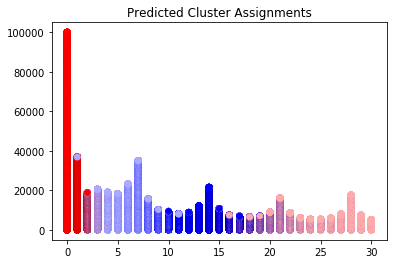

In [23]:
y = np.zeros(N)
for i in range(31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range(len(indices))]
    y[indices] = values
clusters = qz_Gibbs.sample().eval()
plt.scatter(delay, y, c=clusters, cmap=cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

$\LARGE \mathbf {Criticism\; Again}$

We can use Edward to calculate the log-likelihood.

In [24]:
x_post = ed.copy(x, {pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs})
ed.evaluate('log_likelihood', data={x_post: delay})

-11.947207

Since AIC is the same, we can again calculate
DIC, WAIC and lppd. Compared to what we get from variational
inference, we see that Gibbs sampling provides better inference.

In [25]:
DIC_Gibbs, WAIC_Gibbs, lppd_Gibbs, post_prob_Gibbs = info_crit(
    qpi_Gibbs, qlam_Gibbs, K, delay)
print('DIC: ', DIC_Gibbs)
print('WAIC: ', WAIC_Gibbs)
print('lppd:', lppd_Gibbs)

DIC:  3118546.418589663
WAIC:  3114516.094830907
lppd: -1552725.3590180047


We can again plot the posterior probabilities.
It's still not exactly like
the histogram of the dataset, but it looks
better than the plot from variational inference.

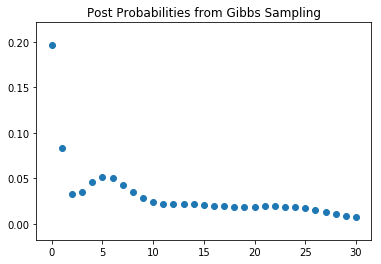

In [26]:
plt.scatter([x for x in range(31)],
            post_prob_Gibbs)
plt.title('Post Probabilities from Gibbs Sampling')
plt.show()

And we can do posterior predictive checks directly
with Edward. And we see that the new datasets
generated from running Gibbs are quite
similar to our original dataset.

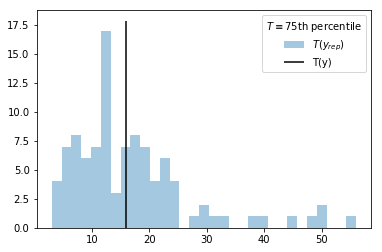

In [27]:
x_post = ed.copy(x, {pi: qpi_Gibbs,
                     lam: qlam_Gibbs, z: qz_Gibbs})
y_rep, y = ed.ppc(lambda xs,
                  zs: tf.contrib.distributions.percentile(xs[x_post], q=75),
                  data={x_post: delay})
ed.ppc_stat_hist_plot(y[0], y_rep,
                      stat_name=r'$T \equiv$75th percentile', bins=31)
plt.show()

$\LARGE \mathbf {Changing\; K}$

We can check if the model is better if
we have one more or one less cluster. We
start with having $5$ clusters instead
of $4$. We run Gibbs sampling and do some ppc.

mixing proportion:  [0.29354784 0.2140184  0.16673075 0.14336959 0.18233357]
cluster mean:  [ 5.891311   23.655807    0.16274902  0.9996776  13.860607  ]


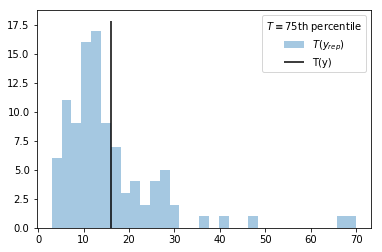

In [28]:
K = 5
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape=K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape=N)
z = x.cat

qpi_5 = Empirical(tf.get_variable(
                 "qpi_5", [T, K],
                 initializer=tf.constant_initializer(1.0 / K)))
qlam_5 = Empirical(tf.get_variable(
                  "qlam_5", [T, K],
                  initializer=tf.zeros_initializer()))
qz_5 = Empirical(tf.get_variable(
                "qz_5", [T, N],
                initializer=tf.zeros_initializer(), dtype=tf.int32))

inference = ed.Gibbs({pi: qpi_5, lam: qlam_5,
                      z: qz_5}, data={x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_5.mean().eval())
print('cluster mean: ', qlam_5.mean().eval())

x_post = ed.copy(x, {pi: qpi_5, lam: qlam_5, z: qz_5})
y_rep, y = ed.ppc(lambda xs,
                  zs: tf.contrib.distributions.percentile(xs[x_post], q=75),
                  data={x_post: delay})
ed.ppc_stat_hist_plot(y[0], y_rep,
                      stat_name=r'$T \equiv$75th percentile', bins=31)
plt.show()

In [29]:
DIC_5, WAIC_5, lppd_5, post_prob_5 = info_crit(qpi_5, qlam_5, K, delay)
print('DIC: ', DIC_5)
print('WAIC: ', WAIC_5)
print('lppd:', lppd_5)

DIC:  3102516.2300808053
WAIC:  3102494.9033891666
lppd: -1549982.0691184723


We see that two of the cluster means now are very close
and the rest are pretty much the same as before.
The information criteria are also pretty close.
So it's probably not a better model. We can also
do the same for $3$ clusters. But we again see
that the statistics are quite similar, so
the model is not much better.

mixing proportion:  [0.33506724 0.30503368 0.35989895]
cluster mean:  [20.682337    0.48234338  6.64784   ]


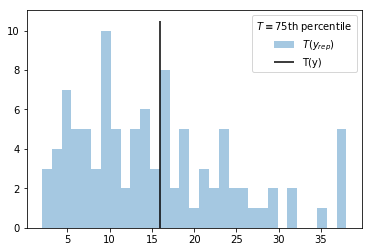

In [30]:
K = 3
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape=K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape=N)
z = x.cat

qpi_3 = Empirical(tf.get_variable(
                 "qpi_3", [T, K],
                 initializer=tf.constant_initializer(1.0 / K)))
qlam_3 = Empirical(tf.get_variable(
                  "qlam_3", [T, K],
                  initializer=tf.zeros_initializer()))
qz_3 = Empirical(tf.get_variable(
                "qz_3", [T, N],
                initializer=tf.zeros_initializer(), dtype=tf.int32))

inference = ed.Gibbs({pi: qpi_3, lam: qlam_3, z: qz_3}, data={x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_3.mean().eval())
print('cluster mean: ', qlam_3.mean().eval())

x_post = ed.copy(x, {pi: qpi_3, lam: qlam_3, z: qz_3})
y_rep, y = ed.ppc(lambda xs,
                  zs: tf.contrib.distributions.percentile(xs[x_post], q=75),
                  data={x_post: delay})
ed.ppc_stat_hist_plot(y[0], y_rep,
                      stat_name=r'$T \equiv$75th percentile', bins=31)
plt.show()

In [31]:
DIC_3, WAIC_3, lppd_3, post_prob_3 = info_crit(qpi_3, qlam_3, K, delay)
print('DIC: ', DIC_3)
print('WAIC: ', WAIC_3)
print('lppd:', lppd_3)

DIC:  3151782.616926396
WAIC:  3153409.1076673213
lppd: -1572004.0880480474


$\LARGE \mathbf {Conclusion}$

In this project, we aim to make inference
about how far in advance people usually make
appointments using a mixtures of Poissons
model. We can use EM algorithm to find the
maximum likelihood estimators, but doing Bayesian
analysis is harder. Because there is too much
variance in BBVI, it's hard to get good variational
posteriors, and one can try to include control
variates in the future to make better variational
inference. Fortunately, with certain choices of
priors, we can use Gibbs sampling to get posteriors
that yield good posterior predictive checks. It
seems that we have a reasonable model for the
data, but it's also interesting to explore other models.